In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_07 import *

# BatchNorm
> Layer Normalization 

With basic parameter initialization we can only get so far. The next step would be normalize our activations inside the model. 

This is idea behind BatchNorm and its many variants.

## Data, Model, and Runner

We'll start how we normally do: get the mnist data, put together our callbacks, runner and learner and then train.

In [8]:
x_train, y_train, x_valid, y_valid = get_data()

train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [9]:
mnist_view = view_tfm(1,28,28)
callbacks = [
    Recorder,
    partial(AvgStatsCallback, accuracy),
    partial(BatchTransformXCallback, mnist_view),
    CudaCallback
]

In [11]:
nfs = [8,16,32,64,64]

learn, run = get_learn_run(data, nfs, conv_layer, lr=0.4, cbs=callbacks)

Layer Initialized torch.Size([8, 1, 5, 5])
Layer Initialized torch.Size([16, 8, 3, 3])
Layer Initialized torch.Size([32, 16, 3, 3])
Layer Initialized torch.Size([64, 32, 3, 3])
Layer Initialized torch.Size([64, 64, 3, 3])


In [12]:
%time run.fit(3, learn)

train: [1.68463625, tensor(0.4336, device='cuda:0')]
valid: [0.52238818359375, tensor(0.8305, device='cuda:0')]
train: [0.277206171875, tensor(0.9145, device='cuda:0')]
valid: [0.18055904541015624, tensor(0.9444, device='cuda:0')]
train: [0.1611205859375, tensor(0.9504, device='cuda:0')]
valid: [0.12373504638671876, tensor(0.9620, device='cuda:0')]
Wall time: 6.28 s


## Norms

### Custom BatchNorm Module

We'll start by implementing BatchNorm from stratch based on the paper "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" by Sergey Ioffe and Christian Szegedy

BatchNorm comes down to essentially 4 steps:

1. Find the mean of the mini-batch.
$$ \mu_{\beta} \leftarrow \frac{1}{m} \sum_{i=1}^m x_i$$

2. Find the variance of the mini-batch:
$$\sigma^2_{\beta} \leftarrow \frac{1}{m} \sum_{i=1}^m (x_i - \mu_{\beta})^2$$

3. Normalize the mini-batch with these two statistics:
$$ \hat{x}_i \leftarrow \frac{x_i - \mu_{\beta}}{\sqrt{\sigma_{\beta}^2 + \epsilon} }$$

4. Scale and shift:
$$y_i \leftarrow \gamma \hat{x}_i + \beta \equiv BN_{\gamma, \beta}(x_i)$$

And this BatchNorm.

We'll implement this in a similar way as we created the `Generalized ReLU` - as a `nn.Module` child which can easily be placed into our `get_conv_layers` function as any other module we're using (linear, Conv2d, etc)

In [40]:
class BatchNorm(nn.Module):
    
    def __init__(self, nf, mom=0.1, eps= 1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        
        # learnable parameters gamma and beta from the equation above
        self.mults = nn.Parameter(torch.ones(nf, 1,1)) 
        self.adds = nn.Parameter(torch.zeros(nf, 1,1)) 
    
        # buffers that will be serialized and sent to the GPU but not optimized 
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        
    def update_stats(self, x):
        # mini-batch stats
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        
        # exponentially weighted moving average
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v
         
    def forward(self, x):
        if self.training: #checks if training or inference
            with torch.no_grad(): m,v = self.update_stats(x)
        else:
            m,v = self.means, self.vars # if inference use saved means and vars
        # normalize the batch    
        x = (x-m) / (v+self.eps).sqrt()
        
        # scale and shift by learnable parameters
        return x*self.mults + self.adds

Now we'll need to tweak our `conv_layer` function to add a `BatchNorm` to each conv layer:

In [41]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # no bias if using bn
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf, **kwargs))
    return nn.Sequential(*layers)

Let's also refactor our `init_cnn` using the factory method and make a recursive `init_cnn_` that traverses the model's modules:

In [63]:
#export
def init_cnn_(m, func):
    if isinstance(m, nn.Conv2d):
        func(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, func)

def init_cnn(model, uniform=False):
    initzer = init.kaiming_normal_ if not uniform else init.kaiming_uniform_
    init_cnn_(model, initzer)

Reload `get_learn_run` with new functions:

In [64]:
#export
def get_learn_run(data, nfs, layer, lr, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

train: [0.3679563671875, tensor(0.8915, device='cuda:0')]
valid: [0.1815224609375, tensor(0.9462, device='cuda:0')]


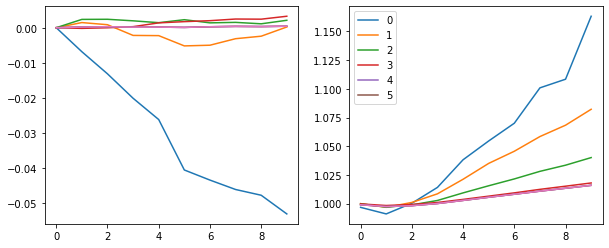

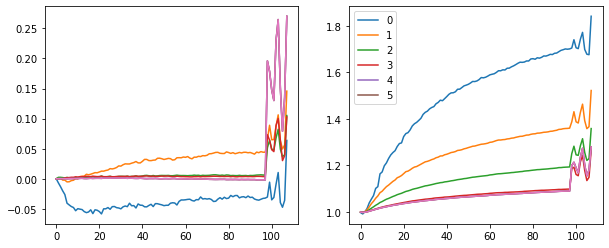

In [56]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.4, cbs=callbacks)

with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))
    

With a learning rate of `0.4` we get to `89%` validation accuracy after 1 epoch.

Let's turn up the learning rate and see how our means and stds hold up.

train: [0.27656984375, tensor(0.9143, device='cuda:0')]
valid: [0.14410179443359375, tensor(0.9543, device='cuda:0')]


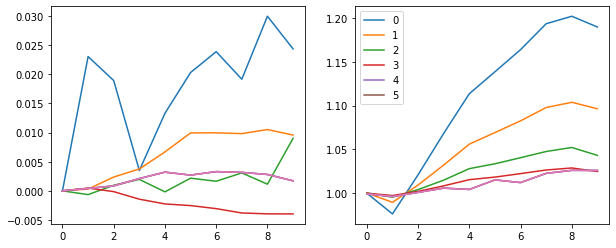

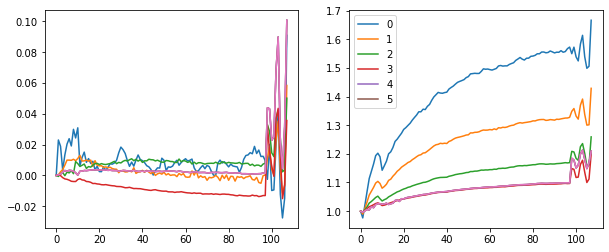

In [57]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.9, cbs=callbacks)

with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))
    
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats[0], h.stats[1]
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))
    

 Accuracy improved.
 
 But what is happening in last iterations? The means and stds start jumping around. Those are the validations batches...

In [58]:
learn, run = get_learn_run(data, nfs, conv_layer, 1.0, cbs=callbacks)

In [59]:
run.fit(4, learn)

train: [0.2599489453125, tensor(0.9184, device='cuda:0')]
valid: [0.14667977294921875, tensor(0.9544, device='cuda:0')]
train: [0.0830198828125, tensor(0.9741, device='cuda:0')]
valid: [0.1447244873046875, tensor(0.9553, device='cuda:0')]
train: [0.062143818359375, tensor(0.9811, device='cuda:0')]
valid: [0.12630584716796875, tensor(0.9621, device='cuda:0')]
train: [0.04956205078125, tensor(0.9844, device='cuda:0')]
valid: [0.08300305786132813, tensor(0.9771, device='cuda:0')]


#### `register_buffer`

We use the Pytorch `register_buffer` method for the `mults` and `adds` attributes. It adds some functionality that will helpful later:
    
    1. Moves to GPU 
    2. When the model is saved/serialized later, it saves any tensors registered as buffers will be saved.
    3. Buffers are not trained by the optimizer - they won’t be returned in model.parameters(), so that the optimizer won’t have a chance to update them.
    

If you have parameters in your model, which should be saved and restored in the `state_dict`, but not trained by the optimizer, you should register them as buffers.

In [13]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.my_tensor = torch.randn(1)
        self.register_buffer('my_buffer', torch.randn(1))
        self.my_param = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
            return x

In this case `my_tensor` is not saved as a `parameter` or `buffer` - its simply a class attribute.

In [14]:
mm = MyModel()
print(mm.my_tensor)

tensor([-1.0946])


There is only one parameter in the model:

In [17]:
for l in mm.parameters(): print(l)

Parameter containing:
tensor([0.7329], requires_grad=True)


And the `state_dict` contains `my_param` and `my_buffer`

In [15]:
print(mm.state_dict())

OrderedDict([('my_param', tensor([0.7329])), ('my_buffer', tensor([1.7349]))])


Now if we push everything onto the GPU we can see that the parameters and buffers get pushed onto the GPU but the `my_tensor` remains on the CPU:

In [18]:
mm.cuda()
print(mm.my_tensor)

tensor([-1.0946])


In [19]:
print(mm.state_dict())

OrderedDict([('my_param', tensor([0.7329], device='cuda:0')), ('my_buffer', tensor([1.7349], device='cuda:0'))])


#### `torch.lerp`

Does a linear interpolation of two tensors `start` (given by input) and `end` based on a scalar or tensor weight and returns the resulting out tensor.

$$ \text{out}_i = \text{start}_i + \text{weight}_i \times (\text{end}_i - \text{start}_i) $$

In [72]:
# torch.lerp()

Let's plot this to see it:

In [ ]:
# plot

### Pytorch BatchNorm Module

And now for the Pytorch `nn.BatchNorm2d` module:

In [62]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # no bias if using bn
    layers = [nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=stride, bias=not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-05, momentum=0.1))
    return nn.Sequential(*layers)

In [65]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.7, cbs=callbacks)

In [67]:
%time run.fit(4, learn)

train: [0.02761480224609375, tensor(0.9919, device='cuda:0')]
valid: [0.05904262084960937, tensor(0.9830, device='cuda:0')]
train: [0.02142716064453125, tensor(0.9938, device='cuda:0')]
valid: [0.06160291748046875, tensor(0.9833, device='cuda:0')]
train: [0.01589372314453125, tensor(0.9952, device='cuda:0')]
valid: [0.0585930419921875, tensor(0.9821, device='cuda:0')]
train: [0.0131391162109375, tensor(0.9964, device='cuda:0')]
valid: [0.06354718017578125, tensor(0.9811, device='cuda:0')]
Wall time: 5.76 s


To improve this even more let's add our param scheduler callback:

In [68]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [69]:
learn, run = get_learn_run(data, nfs, conv_layer, 0.7, cbs=callbacks+[partial(ParamScheduler, 'lr', sched)])

In [70]:
run.fit(8, learn)

train: [0.249917421875, tensor(0.9245, device='cuda:0')]
valid: [0.1623446044921875, tensor(0.9505, device='cuda:0')]
train: [0.08056126953125, tensor(0.9747, device='cuda:0')]
valid: [0.1376042236328125, tensor(0.9606, device='cuda:0')]
train: [0.0730627294921875, tensor(0.9787, device='cuda:0')]
valid: [0.0695763427734375, tensor(0.9804, device='cuda:0')]
train: [0.03628987060546875, tensor(0.9888, device='cuda:0')]
valid: [0.0558621826171875, tensor(0.9837, device='cuda:0')]
train: [0.02227659423828125, tensor(0.9932, device='cuda:0')]
valid: [0.05410006103515625, tensor(0.9850, device='cuda:0')]
train: [0.013878924560546875, tensor(0.9962, device='cuda:0')]
valid: [0.048078955078125, tensor(0.9861, device='cuda:0')]
train: [0.008938154296875, tensor(0.9980, device='cuda:0')]
valid: [0.046859091186523434, tensor(0.9873, device='cuda:0')]
train: [0.006260599975585938, tensor(0.9988, device='cuda:0')]
valid: [0.0464509033203125, tensor(0.9875, device='cuda:0')]


We're at 98.7% accuracy for our validation set - that means we're wrong on about 650 out of the 50,000 digits we see. 

In [79]:
49350 / len(data.valid_ds) 

0.987

### Layer Norm

### Instance Norm

### Group Norm

## Fix Small Batch Sizes